# Vocalization Classification

Using the spectral features, I will train a classifier based on the words: {BRICK, CLOCK, JUICE, PANTS, GLASS} and determine how well different classifiers perform using this data.

In [46]:
# Import Necessary Libraries
import numpy as np
import scipy.io

import csv
import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.decomposition import PCA
import scipy.stats as stats
from scipy.spatial import distance as Distance

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

In [11]:
#### Extract wordpairs data into a dictionary for a subject/session/block
#### dictionary{wordpair:{channels}}
def extractSubjVocalizedData(subj, word):
    # file directory for a subj/session/block
    filedir = '../../condensed_data_' + subj + '/summary_vocalization/' + word
    
    # initialize data dictionary with meta data
    data_dict = {}
    data_dict['meta'] = {'subject': subj,
                         'word': word}
    
    all_channel_mats = os.listdir(filedir)
    for channel in all_channel_mats: # loop thru all channels
        chan_file = filedir + '/' + channel

        ## 00: load in data
        data = scipy.io.loadmat(chan_file)
        data = data['data']

        ## 01: get the time point for probeword on
        timeZero = data['timeZero'][0][0][0]

        ## 02: get the time point of vocalization
        vocalization = data['vocalization'][0][0][0]

        ## 03: Get Power Matrix
        power_matrix = data['powerMatZ'][0][0]

        chan = channel.split('_')[0]

        # convert channel data into a json dict
        data_dict[chan] = {'timeZero': timeZero,
                                      'timeVocalization':vocalization,
                                      'powerMat': power_matrix}
    return data_dict

def extractSubjVocalizedDataCat(subj, word):
    # file directory for a subj/session/block
    filedir = '../../condensed_data_' + subj + '/summary_vocalization/' + word
    
    # initialize data dictionary with meta data
    data_dict = {}
    data_dict['meta'] = {'subject': subj,
                         'word': word}
    
    all_channel_mats = os.listdir(filedir)
    for cdx, channel in enumerate(all_channel_mats): # loop thru all channels
        chan_file = filedir + '/' + channel

        ## 00: load in data
        data = scipy.io.loadmat(chan_file)
        data = data['data']

        ## 01: get the time point for probeword on
        timeZero = data['timeZero'][0][0][0]

        ## 02: get the time point of vocalization
        vocalization = data['vocalization'][0][0][0]

        ## 03: Get Power Matrix
        power_matrix = data['powerMatZ'][0][0]
        power_matrix = power_matrix[:, :, timeZero:timeZero+25]
        
        chan = channel.split('_')[0]

        # convert channel data into a json dict
        if cdx == 0:
            data_dict['data'] = {'timeZero': timeZero,
                             'timeVocalization':vocalization,
                             'powerMat': power_matrix}
        else:
            data_dict['data']['powerMat'] = np.concatenate((data_dict['data']['powerMat'], power_matrix), axis=1)
        
    return data_dict

In [13]:
######## Get list of files (.mat) we want to work with ########
subj = 'NIH034' # change the directories if you want
filedir = '../../condensed_data_' + subj + '/summary_vocalization/'
targetWords = os.listdir(filedir)

print targetWords

spectralData = {}
for word in targetWords:
    wordDir = filedir + word
    
    ## 01: Extract the data of every channel for this subject and targetWord
    wordData = extractSubjVocalizedDataCat(subj, word)
    spectralData[word] = wordData['data']['powerMat']

['BRICK', 'CLOCK', 'GLASS', 'JUICE', 'PANTS']


/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:62: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [14]:
print spectralData.keys()

['JUICE', 'GLASS', 'BRICK', 'PANTS', 'CLOCK']


# Train Classifiers

In [15]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


In [27]:
np.random.seed(12345678)  # for reproducibility, set random seed

names = ["Nearest Neighbors", "Linear SVM", "Random Forest",
         "Linear Discriminant Analysis", "Quadratic Discriminant Analysis",
        "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

In [24]:
comb = sum([map(list, itertools.combinations(targetWords, 2))], [])
print comb

[['BRICK', 'CLOCK'], ['BRICK', 'GLASS'], ['BRICK', 'JUICE'], ['BRICK', 'PANTS'], ['CLOCK', 'GLASS'], ['CLOCK', 'JUICE'], ['CLOCK', 'PANTS'], ['GLASS', 'JUICE'], ['GLASS', 'PANTS'], ['JUICE', 'PANTS']]


In [25]:
accuracy=np.zeros((len(comb),len(classifiers),2))
print accuracy.shape
for i,pair in enumerate(comb): 
    # Create classes and feature vects
    firstWordData = np.mean(spectralData[pair[0]], axis=2)
    secondWordData = np.mean(spectralData[pair[1]], axis=2)

    features = np.append(firstWordData, secondWordData, axis=0)
    y = np.ones((firstWordData.shape[0],))
    y = np.concatenate((y, np.zeros((secondWordData.shape[0],))))
    
    print "\n"
    print("Accuracy for pair: ", pair)
    for idx, cla in enumerate(classifiers):
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, y, test_size=0.4, random_state=0)

        clf = cla.fit(X_train, y_train)
        loo = LeaveOneOut(len(features))
        scores = cross_validation.cross_val_score(clf, features, y, cv=loo)
        accuracy[i,idx,] = [scores.mean(), scores.std()]
        print("Accuracy of %s: %0.2f (+/- %0.2f)" % (names[idx], scores.mean(), scores.std() * 2))

(10, 4, 2)


('Accuracy for pair: ', ['BRICK', 'CLOCK'])
Accuracy of Nearest Neighbors: 0.55 (+/- 0.99)
Accuracy of Linear SVM: 0.58 (+/- 0.99)
Accuracy of Random Forest: 0.67 (+/- 0.94)
Accuracy of Linear Discriminant Analysis: 0.62 (+/- 0.97)


('Accuracy for pair: ', ['BRICK', 'GLASS'])
Accuracy of Nearest Neighbors: 0.89 (+/- 0.63)
Accuracy of Linear SVM: 0.90 (+/- 0.60)
Accuracy of Random Forest: 0.88 (+/- 0.65)
Accuracy of Linear Discriminant Analysis: 0.92 (+/- 0.54)


('Accuracy for pair: ', ['BRICK', 'JUICE'])
Accuracy of Nearest Neighbors: 0.82 (+/- 0.77)
Accuracy of Linear SVM: 0.79 (+/- 0.81)
Accuracy of Random Forest: 0.83 (+/- 0.75)
Accuracy of Linear Discriminant Analysis: 0.84 (+/- 0.73)


('Accuracy for pair: ', ['BRICK', 'PANTS'])
Accuracy of Nearest Neighbors: 0.82 (+/- 0.76)
Accuracy of Linear SVM: 0.82 (+/- 0.76)
Accuracy of Random Forest: 0.83 (+/- 0.75)
Accuracy of Linear Discriminant Analysis: 0.86 (+/- 0.70)


('Accuracy for pair: ', ['CLOCK', 'GLASS'])
Accurac

In [50]:
################### SAVE NORMALIZED LOCATION DATA ###################
# write new list_of_features to new txt file
csvfile = "classification_vocalizedWords.txt"

#Assuming res is a flat list
with open(csvfile, "w") as output:
    # write to new file the data
    writer = csv.writer(output, lineterminator='\n')
    for i in range(0, len(accuracy)):
        writer.writerow('')
        writer.writerow(['Accuracy for pair: ', comb[i][:]])
        for j in range(0, len(names)):
            accuracyLog = ["Accuracy of %s: %0.2f (+/- %0.2f)" % (names[j], accuracy[i][j][0], accuracy[i][j][1])]
            writer.writerow(accuracyLog)

# for i in range(0, len(accuracy)): # loop through combinations
#     print '\n'
#     print('Accuracy for pair: ', comb[i][:])
#     for j in range(0, len(names)): # loop through classifiers
#         print("Accuracy of %s: %0.2f (+/- %0.2f)" % (names[j], accuracy[i][j][0], accuracy[i][j][1]))

(10, 4, 2)


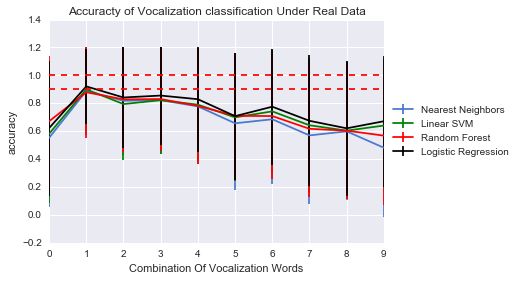

In [44]:
# Plotting accuracy
print accuracy.shape
plt.errorbar(np.arange(0,10), accuracy[:,0,0], yerr = accuracy[:,0,1], hold=True, label=names[0])
plt.errorbar(np.arange(0,10), accuracy[:,1,0], yerr = accuracy[:,1,1], color='green', hold=True, label=names[1])
plt.errorbar(np.arange(0,10), accuracy[:,2,0], yerr = accuracy[:,2,1], color='red', hold=True, label=names[2])
plt.errorbar(np.arange(0,10), accuracy[:,3,0], yerr = accuracy[:,3,1], color='black', hold=True, label=names[3])
# plt.xscale('log')
plt.xlabel('Combination Of Vocalization Words')
plt.ylabel('accuracy')
plt.title('Accuracty of Vocalization classification Under Real Data')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(0.9, color='red', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Classification On Groups

Split the words into 's' sounding words, like glass, juice, pants and 'ck' sounding words like brick and clock.

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "Random Forest",
         "Linear Discriminant Analysis", "Quadratic Discriminant Analysis",
        "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

accuracy=np.zeros((len(classifiers),2))
print accuracy.shape

sGroup = ['JUICE', 'GLASS', 'PANTS']
ckGroup = ['PANTS', 'CLOCK']
print spectralData.keys()
groupedSpectralData = {}
groupedSpectralData['sGroup'] = np.array(())
groupedSpectralData['ckGroup'] = np.array(())
for word in spectralData.keys():
    if word in sGroup:
        if groupedSpectralData['sGroup'].size==0:
            groupedSpectralData['sGroup'] = spectralData[word]
        else:
            groupedSpectralData['sGroup'] = np.concatenate((groupedSpectralData['sGroup'], spectralData[word]), axis=0)
    elif word in ckGroup:
        if groupedSpectralData['ckGroup'].size==0:
            groupedSpectralData['ckGroup'] = spectralData[word]
        else:
            groupedSpectralData['ckGroup'] = np.concatenate((groupedSpectralData['sGroup'], spectralData[word]), axis=0)
print groupedSpectralData.keys()


# Create classes and feature vects
firstGroupData = np.mean(groupedSpectralData['sGroup'], axis=2)
secondGroupData = np.mean(groupedSpectralData['ckGroup'], axis=2)

features = np.append(firstGroupData, secondGroupData, axis=0)
y = np.ones((firstGroupData.shape[0],))
y = np.concatenate((y, np.zeros((secondGroupData.shape[0],))))

print "Accuracy between 's' and 'ck' sounding words: "
for idx, cla in enumerate(classifiers):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, y, test_size=0.4, random_state=0)

    clf = cla.fit(X_train, y_train)
    loo = LeaveOneOut(len(features))
    scores = cross_validation.cross_val_score(clf, features, y, cv=loo)
    accuracy[idx,] = [scores.mean(), scores.std()]
    print("Accuracy of %s: %0.2f (+/- %0.2f)" % (names[idx], scores.mean(), scores.std() * 2))

(6, 2)
['JUICE', 'GLASS', 'BRICK', 'PANTS', 'CLOCK']
['ckGroup', 'sGroup']
Accuracy between 's' and 'ck' sounding words: 
Accuracy of Nearest Neighbors: 0.79 (+/- 0.81)